In [1]:
import numpy as np
import akantu as aka

In [2]:
material_file = """
material elastic [
    name = steel
    rho = 7800     # density
    E   = 1e3   # young's modulus
    nu  = 0.3      # poisson's ratio
]"""

# writing the material file
open('material.dat', 'w').write(material_file)

#reading the material file
material_file = 'material.dat'

In [3]:
# Geo file
ra = 0.5; ri = 0.45;
h = 1;

geo_file = """
SetFactory("OpenCASCADE");

ra = {}; ri = {}; h = {};""".format(ra, ri, h)

geo_file += """
Cylinder(1) = {0, 0, 0, 0, 0, h, ra, 2*Pi};
Cylinder(2) = {0, 0, 0, 0, 0, h, ri, 2*Pi};

vol[] = BooleanDifference{ Volume{1}; Delete; }{ Volume{2}; Delete; };

Physical Volume("body") = {vol[0]};
Physical Surface("inside") = {4};
Physical Surface("bottom") = {7};
Physical Point("fixpoint") = {6};

Mesh.MeshSizeMin = 0.05;
Mesh.MeshSizeMax = 0.1;
Mesh.SaveAll = 1;
Mesh.ElementOrder = 2;

Mesh 3;

Save "hollow_cylinder.msh";
"""
open('hollow_cylinder.geo', 'w').write(geo_file)

import subprocess
subprocess.run('gmsh hollow_cylinder.geo -', shell=True)

CompletedProcess(args='gmsh hollow_cylinder.geo -', returncode=0)

In [4]:
aka.parseInput(material_file)

mesh = aka.Mesh(3)
mesh.read('hollow_cylinder.msh')

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._static)

In [5]:
class hydrostatic_stress(aka.NeumannFunctor):
    def __init__(self, stress):
        super().__init__()
        self.stress = stress

    def __call__(self, quad_point, dual, coord, normals):
        z_coordinate = coord[aka._z]
        dual[:] = np.dot(self.stress, normals)*(h - z_coordinate)




for dir in [aka._x, aka._y, aka._z]:
    model.applyBC(aka.FixedValue(0, dir), "fixpoint")
model.applyBC(aka.FixedValue(0, aka._z), "bottom")
    
stress = np.eye(3)
model.applyBC(hydrostatic_stress(stress), "inside")

In [6]:
solver = model.getNonLinearSolver()
solver.set("max_iterations", 10)
solver.set("threshold", 1e-4)
solver.set("convergence_type", aka.SolveConvergenceCriteria.residual)


model.solveStep()

In [7]:
model.setBaseName("hollow_cylinder")
model.addDumpFieldVector("displacement")
model.addDumpFieldVector("external_force")
model.addDumpField("strain")
model.addDumpField("stress")
model.addDumpField("blocked_dofs")

model.dump()

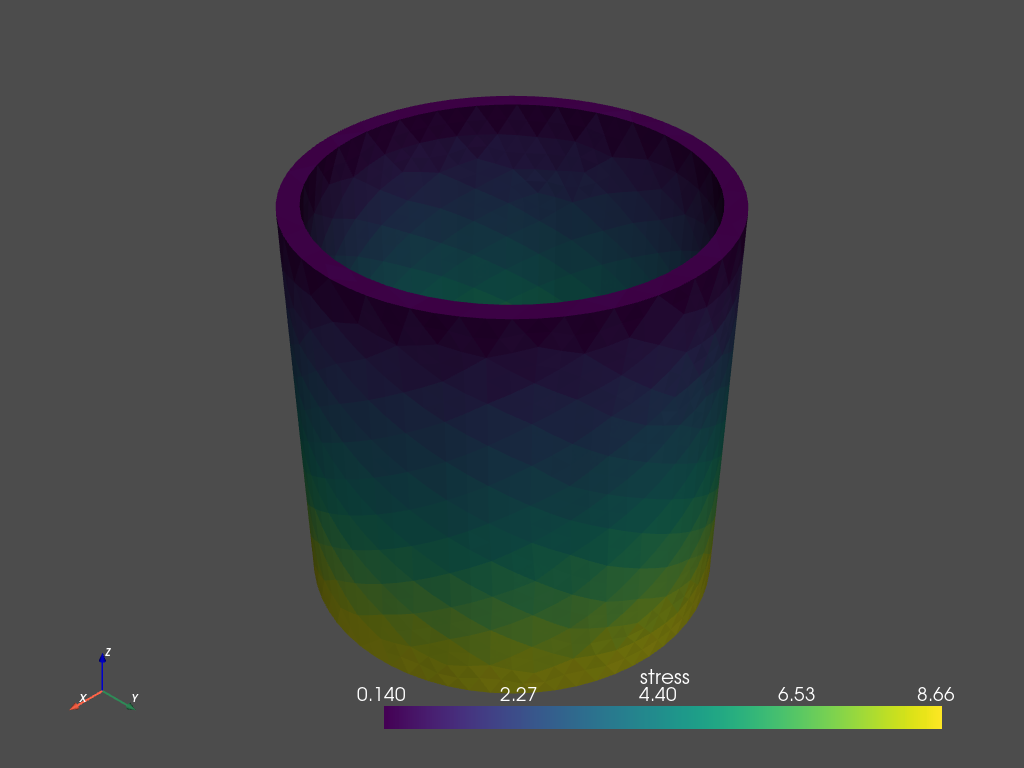

[(1.9318516525781368, 1.9318516525781368, 2.431851652578137),
 (0.0, 0.0, 0.5),
 (0.0, 0.0, 1.0)]

In [2]:
import pyvista as pv

p = pv.Plotter()

hollow_msh = pv.read(f'paraview/hollow_cylinder_{0:04d}.pvtu')
hollow_msh.set_active_scalars('stress')
hollow_warped = hollow_msh.warp_by_vector('displacement')
hollow_warped.set_active_scalars('stress')

hollow_msh.plot()